## Chapter 2 Multi-armed Bandits

In this chapter, it introduces a simple toy system for reinforcement learning - multi-armed bandits. Each arm will give out score. We don't know the exact value (distribution) for each arm. Our task is to develop a plan to give us the highest possible score over a long period of time. 

In reinforcement learning, there is a great problem - conflict between exploration and exloitation. We *explore* to get more accurate knowledge about each arm's score, and *exploit* that knowledge to get as high a score as possible. This seems to me also a great algorithm for many aspects in life. 

Chapter 2 introduces several algorithm for balancing exploration and exploitation (action selection algorithm):
1. greedy: always choose the action with highest estimated value
2. $\epsilon$-greedy: choose the greedy action with $1-\epsilon$ probability, and with $\epsilon$ probability, random choose an action from all possible actions
3. optimistic initial values: give each action a highest possilbe initial value. This allows us to lean towards exploration initially
4. upper confidence bound (UCB): choose the action with the highest upper confidence bound. Highest upper confidence bound either means that we are very unsure about that action, or that action gives a very confident high value.

Along the action selection, we are introduced two methods to estimate the value for each action. The reason we need to explore is that we don't know for sure which arm will give us the highest value. We need to estimate the value distribution for each arm as we gather more data points. 

#### sample average

For each action, we average the past reward for that action:
$$
Q_t(a) = \frac{\sum_{i=1}^{t-1}R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i = a}}
$$
where $R_i$ is the reward at step $i$.

To reduce the memory usage, for the action taken, we can write the value update as following:
$$
Q_{n+1} = Q_n + \frac{1}{n}(R_n - Q_n)
$$

Similar to gradient descent, we call $R_n - Q_n$ the update and $\frac{1}{n}$ the step size. Here the step size decrease with total steps taken $n$.


#### exponential recency-weighted average

Here we fix the step size to $\alpha$:
$$
Q_{n+1} = Q_n + \alpha(R_n - Q_n)
$$

In this case, we give highest weight to the most recent reward. This performs better when we have a non-stationary problem. See below *Exercise 2.5*.

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

***Exercise 2.5*** Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks. Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha=0.1$. Use $\epsilon = 0.1$ and longer runs, say 10000 steps.

In [2]:
# the general structure is borrowed from coursera week 1 assignment
from abc import ABC, abstractmethod

In [11]:
class MultiArmedTestbed(ABC):
    """Abstract class for multi-armed testbed"""
    def __init__(self, n):
        self.num_arms = n
        self.q_true_values = None
        
    @abstractmethod
    def initialize(self):
        pass 
    
    def get_reward(self, action):
        """Return the reward if I pull action-th arm"""
        return self.q_true_values[action]

class NonStationaryTestbed(MultiArmedTestbed):
    """The non-statinoary testbed for this problem: each arm will take an independent random walk on each step"""
    def __init__(self, n):
        super().__init__(n)
        
    def initialize(self):
        """All the $q_*(a)$ start out equal: with value 1"""
        self.q_true_values = np.ones(self.num_arms)
    
    def take_action(self, action):
        """Return the value for the action.
        
        Random walks: normally distributed increment with mean 0, std 0.01
        """
        self.q_true_values += np.random.normal(0, 0.01, size=(self.num_arms, ))
        return self.get_reward(action)

In [12]:
# Take from coursera assignment week 1
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
    return np.random.choice(ties) 

In [17]:
class AbstractAgent(ABC):
    """Abstract class for mutli-arm bandits"""
    
    def __init__(self, num_arms, epsilon):
        self.q_values = np.zeros(num_arms)
        self.arm_count = np.zeros(num_arms)
        self.last_action = -1;
        self.epsilon = epsilon
        
    def episilon_greedy_selection(self):
        """return the action selected by epsilon greedy"""
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)

        return current_action
        
    @abstractmethod
    def agent_step(self, reward):
        """Return the action the agent will take.
        Action selection algorithm: $\epsilon$-greedy
        
        Parameter:
        ==========
        reward: the reward the multi-armed bandit returns after taking last action
        
        return:
        =======
        current_action: the action agent will take
        """
        pass
    

class SampleAverageAgent(AbstractAgent):
    """Agent uses sample average to estimate the value
    """
    def __init__(self, num_arms, epsilon):
        super().__init__(num_arms, epsilon)
    
    def agent_step(self, reward):
        # epsilon-greedy to select current action 
        current_action = self.episilon_greedy_selection()
        
        # update the value
        if self.last_action != -1:
            self.arm_count[self.last_action] += 1
            self.q_values[self.last_action] = self.q_values[self.last_action] + 1/(self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])

        self.last_action = current_action
        
        return current_action
    
    
class ConstantStepSizeAgent(AbstractAgent):
    """Agent uses constant step size to estimate the value
    """
    def __init__(self, num_arms, epsilon, alpha):
        self.step_size = alpha
        super().__init__(num_arms, epsilon)
    
    def agent_step(self, reward):
        # epsilon-greedy to select current action 
        current_action = self.episilon_greedy_selection()
        
        # update the value   
        if self.last_action != -1:
            self.arm_count[self.last_action] += 1
            self.q_values[self.last_action] = self.q_values[self.last_action] + self.step_size * (reward - self.q_values[self.last_action])
        
        self.last_action = current_action
        
        return current_action

In [38]:
num_runs = 100
steps = 20000

num_arms = 10
epsilon = 0.01

sa_reward = np.zeros(shape=(num_runs, steps))
cs_reward = np.zeros(shape=(num_runs, steps))

for i in tqdm(range(num_runs)):
    # initialize the experiment: initial reward, agent, and testbed
    sa_rt = 0
    cs_rt = 0
    sa_agent = SampleAverageAgent(num_arms, epsilon)
    cs_agent = ConstantStepSizeAgent(num_arms, epsilon, 0.1)
    testbed = NonStationaryTestbed(num_arms)
    testbed.initialize()
    
    for stp in range(steps):
        sa_a = sa_agent.agent_step(sa_rt)
        cs_a = cs_agent.agent_step(cs_rt)
    
        sa_rt = testbed.take_action(sa_a)
        sa_reward[i, stp] = sa_rt
        cs_rt = testbed.get_reward(cs_a)
        cs_reward[i, stp] = cs_rt


100%|██████████| 100/100 [01:14<00:00,  1.33it/s]


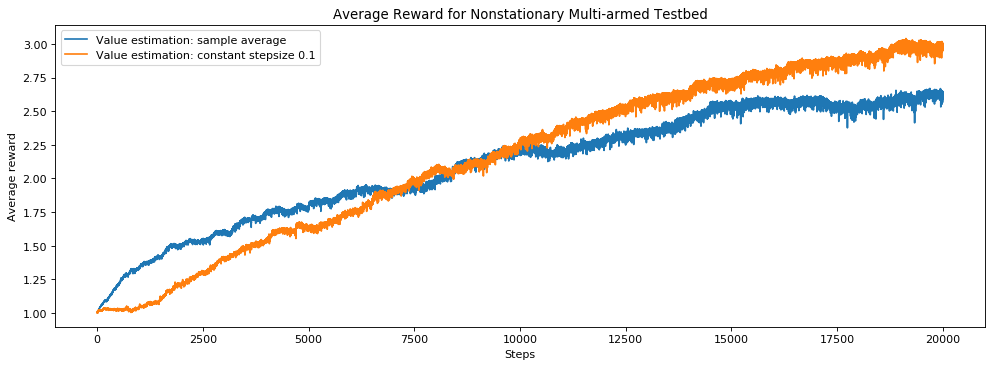

In [39]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.mean(sa_reward, axis=0), label='Value estimation: sample average')
plt.plot(np.mean(cs_reward, axis=0), label="Value estimation: constant stepsize 0.1")
plt.legend()
plt.title("Average Reward for Nonstationary Multi-armed Testbed")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

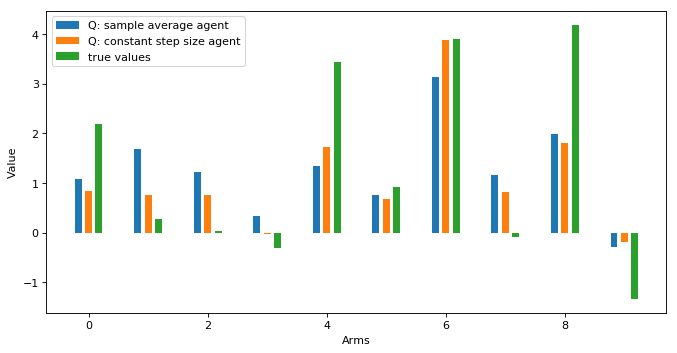

In [48]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
width = 0.35
bars = np.arange(num_arms)
plt.bar(bars - width/2, sa_agent.q_values, width/3, label='Q: sample average agent')
plt.bar(bars, cs_agent.q_values, width/3, label='Q: constant step size agent')
plt.bar(bars + width/2, testbed.q_true_values, width/3, label='true values')
plt.xlabel('Arms')
plt.ylabel('Value')
plt.legend()

From the experiment, for non-stationary multi-armed bandits, eventually constant-stepsize value estimation outperforms the sample average method. 